In [548]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from fiona.crs import from_epsg
from shapely.geometry import Point

# Load Data
* path_parks: where to find the historical park permit data
* parkpop: a dataset of all the people living within 10-minutes walking distance.
* parks: a shapefile of all NYC parks

In [549]:
path_parks= r'M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\Parks Historical Permits'

In [550]:
parkpop= pd.read_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\190718_10 Min Walksheds with Population_JG\190718_10minwalksheds_pop.csv")

In [551]:
parkpop.head()

,GISPROPNUM,TYPECATEGO,Pop_nearPark,ShapeArea_Walkshed,Park Acres,PopDens
0,B001,Playground,10297.881979,203.212770,0.896,50.675368
1,B006,Triangle/Plaza,21108.864450,239.452140,0.012,88.154837
2,B007,Recreation Field/Courts,18229.304533,232.010714,17.500,78.570960
3,B008,NaN,29051.844266,363.630316,NaN,79.893900
4,B012,Neighborhood Park,31806.977333,323.364494,7.047,98.362615


In [552]:
parks= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\RAW\NYC_PARKS_DATA\NYCPARKS_ALLSITES.shp")

In [553]:
park_entrances= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Walk-to-a-Park Summer 2019 Data\Walk-to-a-Park Summer 2019 Data\Walk to a Park 2019_Reprojected.shp")

In [554]:
path_exp= r"M:\NY4P Metrics Research 18034\05_GRAPHICS\Charts Graphs Diagrams\190729_Park Scores - NY4P Categories\plt saves"
#where to export files

## Setting up parks and park categories (DPR or NY4P)

In [555]:
parks['TYPECATEGO'].unique()

array(['Community Park', 'Recreation Field/Courts', 'Neighborhood Park',
       'Nature Area', 'Waterfront Facility', 'Historic House Park',
       'Playground', 'Undeveloped', 'Buildings/Institutions', 'Parkway',
       'Jointly Operated Playground', 'Triangle/Plaza', 'Managed Sites',
       'Lot', 'Strip', 'Cemetery', 'Flagship Park', 'Mall', 'Tracking'],
      dtype=object)

In [556]:
parks[parks['GISPROPNUM']=='M010']
#Is central park included?

,GISPROPNUM,LOCATION,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,ACRES,ADDRESS,SIGNNAME,TYPECATEGO,WATERFRONT,NYS_ASSEMB,NYS_SENATE,US_CONGRES,geometry
1561,M010,"5 Av To Central Park W, 59 St To 110 St","110, 111, 107, 105, 108, 106",6,18,"10023, 10024, 10025",M,840.01,1000 5 AVENUE,Central Park,Flagship Park,No,"69, 68, 67, 75",29,"10, 13",(POLYGON ((995951.7570963055 230838.4251838028...


## NY4P Categories
* comment out if necessary
* converts column TYPECATEGO from DPR categories to NY4P categories

In [557]:
#Using NY4P Categories
parks.loc[parks['ACRES']<1,'TYPECATEGO']='PP'
parks.loc[(parks['ACRES']>=1)&(parks['ACRES']<=20),'TYPECATEGO']='NP'
parks.loc[(parks['ACRES']>20),'TYPECATEGO']='LP'

In [558]:
parks['TYPECATEGO'].unique()

array(['LP', 'NP', 'PP'], dtype=object)

## Joining permit data to NY4P data
* perms: historical permit data
* iso: a shapefile of all park walking distances (with 10-minute walking distances)

In [559]:
blocks= gpd.read_file(r"S:\NYC_GIS_DATA\Census block groups 2010\tl_2010_36_bg10.shp")
#shapefile of census blockgroups

In [560]:
perms= pd.read_csv(join(path_parks, '190618_ParksPermits_ADDCOLS.csv'), low_memory=False, index_col=0)

In [561]:
#perms.loc[(perms['park_clean'].str.contains('east river park m'))&(perms['event_location'].notna()),'GISPROPNUM']= 'M144'
# Uncomment to manually add the East River Park

In [562]:
perms.shape
#228,844 events in NYC!

(228844, 23)

In [563]:
perms= pd.merge(perms.drop('TYPECATEGO',axis=1),parks[['GISPROPNUM','TYPECATEGO']],on='GISPROPNUM',how='right')
#Specifying the parks that we've filtered
# right or inner will change whether we include all parks or only parks with events

In [564]:
perms['start_date_time']= pd.to_datetime(perms['start_date_time'])
perms['end_date_time']= pd.to_datetime(perms['end_date_time'])

perms['year']= perms['start_date_time'].dt.year
perms['start_time']= perms['start_date_time'].dt.time
perms['end_time']= perms['end_date_time'].dt.time

perms['date']= perms['start_date_time'].dt.date
perms['dow']= perms['start_date_time'].dt.weekday

In [565]:
#perms= perms[~(perms['event_name']=='Miscellaneous')].copy()

In [566]:
iso= gpd.read_file(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Isochrones\190718_Isochrones_JG\190719_10 Min Walksheds with Pop and Pop Density.shp")

In [567]:
iso.loc[iso['ACRES']<1,'TYPECATEGO']='PP'
iso.loc[(iso['ACRES']>=1)&(iso['ACRES']<=20),'TYPECATEGO']='NP'
iso.loc[(iso['ACRES']>20),'TYPECATEGO']='LP'
#setting iso TYPECATEGO to NY4P categories, comment out if necessary

In [568]:
iso.shape

(818, 21)

In [569]:
parks.shape
#818 out of 1,709 parks!

(1709, 16)

In [570]:
iso['GISPROPNUM'].unique().shape

(818,)

In [571]:
iso= iso.to_crs({'init':'epsg:2263'})

In [572]:
blocks= blocks.to_crs({'init':'epsg:2263'})

In [573]:
parkiso= pd.merge(iso[['GISPROPNUM','geometry']],parkpop,on='GISPROPNUM',how='inner')

In [574]:
parkiso= parkiso[parkiso['GISPROPNUM'].isin(parks['GISPROPNUM'].unique())]

In [575]:
parkiso.shape
#Merging isochrones and nearby population to park information!

(818, 7)

# Initial Options
* (1) Total Permits by Park (TP)
* (2) Total Permits per Acre by Park (TPA)
* (3) Total Permits per Person (TPPop)
* (4) Total Permits per Person per Walkshed Acre (TPPopDens)

## Total Permits by Park Type, MM and LMM Normalization
* mask_1318: filters for the correct permit years
* y2y groups all permits by year and by park

In [576]:
mask_1318= perms['year'].isin(np.arange(2013,2019,1))

In [577]:
y2y= perms[perms['year'].isin(np.arange(2013,2019,1))].groupby(['GISPROPNUM','year']).agg({'GISPROPNUM':'count'}).unstack()

In [578]:
parklist= y2y['GISPROPNUM'].index.unique()
parklist.shape
#830 parks in the y2y dataset

(830,)

In [579]:
parks['GISPROPNUM'].unique().shape
#1,709 parks in total

(1709,)

In [580]:
park_entrances[park_entrances['gispropnum'].isin(parklist)&(~park_entrances['gispropnum'].isin(parkiso['GISPROPNUM']))]
#all the parks that are in the park entrances data set and in the y2y dataset, but that don't have a corresponding walkshed
#Should be 0 (I checked and manually fixed it)!!

,gispropnum,parkname,type,geometry


In [581]:
y2y.columns= [2013, 2014, 2015, 2016, 2017, 2018]

In [582]:
y2y.fillna(0, inplace=True)

In [583]:
y2y['tp']= y2y[[2013, 2014, 2015, 2016, 2017, 2018]].sum(axis=1)

# Filtering outliers by Percentile
* comment out if unnecessary
* filters: the 95th percentile cut offs for parks by park type

In [584]:
y2y['tp'].sort_values(ascending=False).quantile(.95)
#The 95th percentile

758.55

In [585]:
outlier= y2y[y2y['tp']>758.55]
#DataFrame of Outlier Parks

In [586]:
y2y= pd.merge(parks[['GISPROPNUM','TYPECATEGO', 'ACRES']],y2y.copy().reset_index(),on='GISPROPNUM',how='inner').fillna(1)
#Includes parks with 0 events

In [587]:
park_types= y2y['TYPECATEGO'].unique()
park_types

array(['LP', 'NP', 'PP'], dtype=object)

In [588]:
filters= []
for i in park_types:
    filters+= [y2y[y2y['TYPECATEGO']==i]['tp'].quantile(.95).round(1)]

In [589]:
filters

[4115.0, 495.1, 157.0]

In [590]:
#y2y.loc[y2y['tp']>758.55,'tp']= 758.55

In [591]:
#y2y= y2y[y2y['tp']<=y2y['tp'].sort_values(ascending=False).quantile(.95)]
#Filters for parks with total permitted events less than the 95th percentile

In [592]:
#mask1= (y2y['tp']>filters[0])&(y2y['TYPECATEGO']==park_types[0])
#mask2= (y2y['tp']>filters[1])&(y2y['TYPECATEGO']==park_types[1])
#mask3= (y2y['tp']>filters[2])&(y2y['TYPECATEGO']==park_types[2])
#y2y.loc[(mask1),'tp']= filters[0]
#y2y.loc[(mask2),'tp']= filters[1]
#y2y.loc[(mask3),'tp']= filters[2]
#Filters for parks with total permitted events less than the 95th percentile and by category

### MM and LMM Normalization Process
* tp: total permits
* tp_mm: total permits min-max
* tp_lmm: total permits log min-max

In [593]:
tmax= y2y['tp'].max()
tmin= y2y['tp'].min()

In [594]:
y2y['tp_mm']= (y2y['tp'].apply(lambda x: (x-tmin)/(tmax-tmin))*100).round(0)
y2y['tp_lmm']= (y2y['tp'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100).round(0)

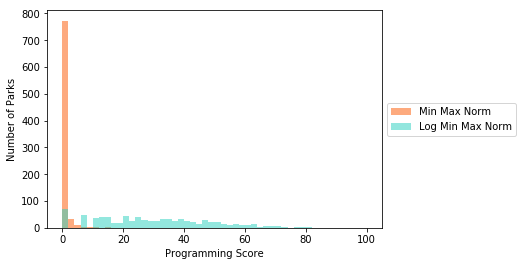

In [595]:
a= y2y['tp_mm'].values
b= y2y['tp_lmm'].values

bins= np.arange(0, 102, 2)

#plt.hist(aa, bins, alpha=0.5, label='All', color='#dfdfdf')
plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')
#plt.hist(a, bins, alpha=0.5, label='Not Reported', color='#9355B0')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events_MM_LMM.pdf'))

plt.show();

In [596]:
y2y.reset_index(inplace=True)
y2y

,index,GISPROPNUM,TYPECATEGO,ACRES,2013,2014,2015,2016,2017,2018,tp,tp_mm,tp_lmm
0,0,Q104,LP,20.340,63.0,76.0,61.0,51.0,65.0,88.0,404.0,1.0,57.0
1,1,X253,NP,6.100,1.0,3.0,1.0,1.0,3.0,5.0,14.0,0.0,25.0
2,2,Q465,NP,6.280,23.0,32.0,21.0,45.0,14.0,26.0,161.0,0.0,48.0
3,3,B379,NP,8.892,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,B385,NP,6.611,31.0,132.0,54.0,27.0,27.0,26.0,297.0,1.0,54.0
5,5,B129,LP,26.257,69.0,142.0,162.0,151.0,172.0,110.0,806.0,2.0,63.0
6,6,B126,LP,58.503,52.0,109.0,92.0,31.0,24.0,49.0,357.0,1.0,56.0
7,7,R008,NP,4.339,7.0,4.0,12.0,11.0,5.0,17.0,56.0,0.0,38.0
8,8,Q371,LP,255.400,1.0,0.0,3.0,2.0,2.0,1.0,9.0,0.0,21.0
9,9,R079,LP,104.545,0.0,2.0,5.0,7.0,2.0,9.0,25.0,0.0,30.0


### Adjust Scores by Park Type

In [597]:
parktypes= ['PP','NP','LP']
#Pocket Park, Neighborhood Park, and Large Park

In [598]:
uparks= perms[~perms[['GISPROPNUM', 'TYPECATEGO']].duplicated()][['GISPROPNUM', 'TYPECATEGO']].reset_index(drop=True)

In [599]:
perms.columns

Index(['community_board', 'end_date_time', 'event_agency', 'event_borough',
       'event_id', 'event_location', 'event_name', 'event_street_side',
       'event_type', 'police_precinct', 'start_date_time',
       'street_closure_type', 'year', 'start_time', 'end_time', 'date', 'dow',
       'event_clean', 'park_short', 'BOROUGH', 'park_clean', 'GISPROPNUM',
       'TYPECATEGO'],
      dtype='object')

In [600]:
y2y= pd.merge(uparks, y2y.drop('TYPECATEGO', axis=1), on='GISPROPNUM', how='right')

In [601]:
fordf= []

for p in parktypes:
    v= y2y[y2y['TYPECATEGO']==p]['tp'].values
    fordf.append([p, v.max(), v.min()])

In [602]:
minmaxes= pd.DataFrame(np.array(fordf), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [603]:
for n, s in minmaxes.iteritems():
    minmaxes[n]= s.astype(np.float32)

In [604]:
minmaxes['DELTA']= minmaxes['MAX']-minmaxes['MIN']

In [605]:
minmaxes

,MAX,MIN,DELTA
TYPECATEGO,,,
PP,725.0,1.0,724.0
NP,5705.0,1.0,5704.0
LP,38611.0,1.0,38610.0


In [606]:
def park_type_adjusted(x, pt, lookup):
    '''
    Performs LMM normalization adjusting for the min
    and max values of the park category.
    '''
    try:
        mi= np.log(lookup.loc[pt, 'MIN'])
        mx= np.log(lookup.loc[pt, 'MAX'])
        dt= mx-mi
        return round((np.log(x)-mi)/dt*100, 0)
    except KeyError:
        return np.nan

In [607]:
y2y['tp_palmm']= [park_type_adjusted(x, pt, minmaxes) for x, pt in y2y[['tp', 'TYPECATEGO']].itertuples(index=False)]

In [608]:
y2y['tp_palmm'].max()

100.0

In [609]:
three_colors= ['#FD5700', '#29D0BF', '#9355B0']

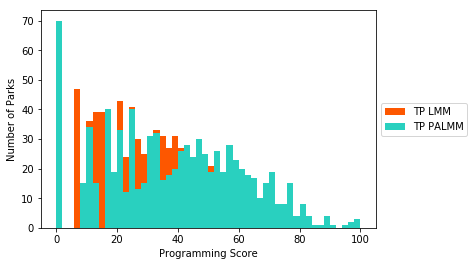

In [610]:
bins= np.arange(0, 102, 2)

tp_lmm= y2y['tp_lmm'].values
tp_palmm= y2y['tp_palmm'].values

plt.hist(tp_lmm, bins,label='TP LMM', color=three_colors[0])
plt.hist(tp_palmm, bins, label='TP PALMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits LMM and Total Permits Adjusted LMM.pdf'))

plt.show();

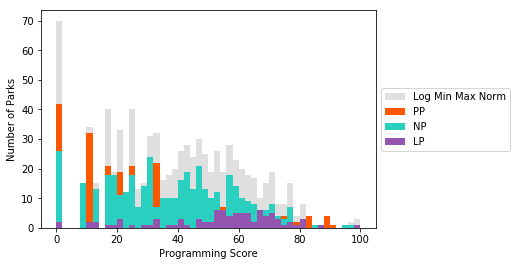

In [611]:
bins= np.arange(0, 102, 2)

plt.hist(y2y['tp_palmm'].values, bins, label='Log Min Max Norm', color='#dfdfdf')

for pt, c in zip(parktypes, three_colors):
    scores= y2y[y2y['TYPECATEGO']==pt]['tp_palmm'].values
    plt.hist(scores, bins,label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Permits Adjusted LMM by Park Type.pdf'))

plt.show();

# Total Permits per Acre by Park Type, MM and LMM
* no0: removes all parks with 0 acres
* tpa: total permits/total park acres
* tpa_palmm: total permits per park acre LMM adjusted by park type

In [612]:
no0= y2y[y2y['ACRES']!=0].copy()

In [613]:
no0['tpa']= no0['tp']/no0['ACRES']

## MM and LMM Normalization

In [614]:
tmax= no0['tpa'].max()
tmin= no0['tpa'].min()

no0['tpa_mm']= no0['tpa'].apply(lambda x: (x-tmin)/(tmax-tmin))*100
no0['tpa_lmm']= no0['tpa'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100

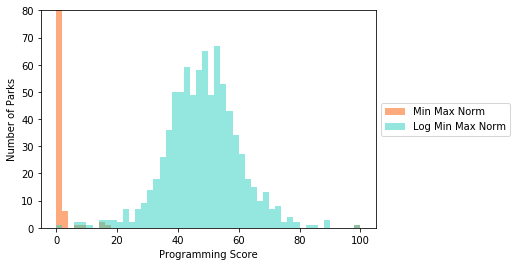

In [615]:
a= no0['tpa_mm'].values
b= no0['tpa_lmm'].values

bins= np.arange(0, 102, 2)

plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Permits per Acre_MM_LMM.pdf'))

plt.show();

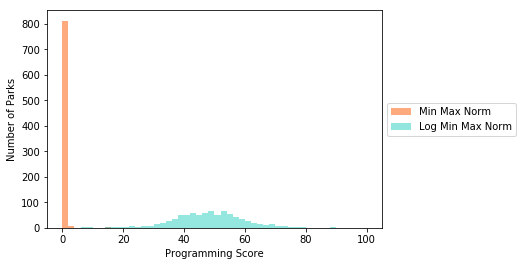

In [616]:
a= no0['tpa_mm'].values
b= no0['tpa_lmm'].values

bins= np.arange(0, 102, 2)

plt.hist(a, bins, alpha=0.5, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, alpha=0.5, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Events by Acre_MM_LMM.pdf'))

plt.show();

## Adjust by Park Type

In [617]:
fordf2= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['tpa'].values
    if len(v)>0:
        fordf2.append([p, v.max(), v.min()])

minmaxes2= pd.DataFrame(np.array(fordf2), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [618]:
minmaxes2

,MAX,MIN
TYPECATEGO,,
LP,61.93900322340689,0.00503826562744041
NP,686.1635220125786,0.07014098337658695
PP,60000.0,1.1111111111111112


In [619]:
no0.loc[no0['tpa'].sort_values(ascending=False).head(10).index]

,GISPROPNUM,TYPECATEGO,index,ACRES,2013,2014,2015,2016,2017,2018,tp,tp_mm,tp_lmm,tp_palmm,tpa,tpa_mm,tpa_lmm
424,B094,PP,627,0.001,22.0,0.0,15.0,2.0,4.0,17.0,60.0,0.0,39.0,62.0,60000.000000,100.000000,100.000000
531,Q058,PP,656,0.003,1.0,2.0,1.0,2.0,2.0,22.0,30.0,0.0,32.0,52.0,10000.000000,16.666660,89.002748
21,M093,PP,471,0.076,99.0,96.0,96.0,96.0,150.0,188.0,725.0,2.0,62.0,100.0,9539.473684,15.899116,88.713376
295,M040,PP,598,0.018,1.0,22.0,22.0,20.0,45.0,47.0,157.0,0.0,48.0,77.0,8722.222222,14.537030,88.163659
243,M188A,PP,531,0.014,10.0,12.0,12.0,10.0,14.0,10.0,68.0,0.0,40.0,64.0,4857.142857,8.095230,84.570514
178,M032,PP,101,0.144,60.0,124.0,122.0,111.0,48.0,111.0,576.0,1.0,60.0,97.0,4000.000000,6.666659,83.378846
99,Q462,PP,591,0.040,7.0,22.0,16.0,11.0,10.0,8.0,74.0,0.0,41.0,65.0,1850.000000,3.083325,78.646025
155,Q172,PP,660,0.041,13.0,21.0,27.0,10.0,0.0,0.0,71.0,0.0,40.0,65.0,1731.707317,2.886171,78.240461
511,Q075,PP,657,0.005,2.0,2.0,1.0,2.0,1.0,0.0,8.0,0.0,20.0,32.0,1600.000000,2.666658,77.754944
224,M101,PP,62,0.269,73.0,36.0,73.0,69.0,41.0,102.0,394.0,1.0,57.0,91.0,1464.684015,2.441132,77.212593


In [620]:
for n, s in minmaxes2.iteritems():
    minmaxes2[n]= s.astype(np.float32)

In [621]:
no0['tpa_palmm']= [park_type_adjusted(x, pt, minmaxes2) for x, pt in no0[['tpa', 'TYPECATEGO']].itertuples(index=False)]
#tpa_palmm = park adjusted log min-max

In [622]:
no0['tpa_palmm']= no0['tpa_palmm'].abs()

In [623]:
tpa_palmm= no0['tpa_palmm'].values

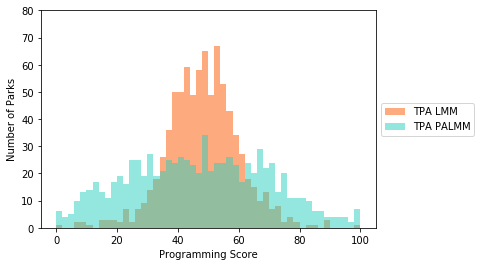

In [624]:
bins= np.arange(0, 102, 2)

tpa_lmm= no0['tpa_lmm'].values
tpa_palmm= no0['tpa_palmm'].values

plt.hist(tpa_lmm, bins, alpha=0.5, label='TPA LMM', color=three_colors[0])
plt.hist(tpa_palmm, bins, alpha=0.5, label='TPA PALMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total by Acre_LMM and Park Type LMM.pdf'))

plt.show();

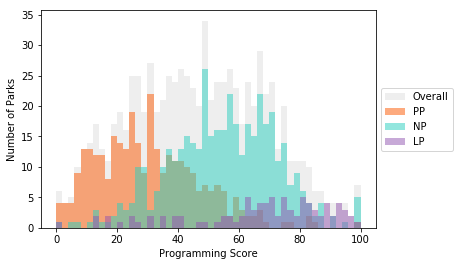

In [625]:
bins= np.arange(0, 102, 2)

plt.hist(tpa_palmm, bins, alpha=0.5, label='Overall', color='#dfdfdf')

for pt, c in zip(parktypes, three_colors):
    scores= no0[no0['TYPECATEGO']==pt]['tpa_palmm'].values
    plt.hist(scores, bins, alpha=0.5, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Premits by Acre_Adjusted LMM by Park Type.pdf'))

plt.show();

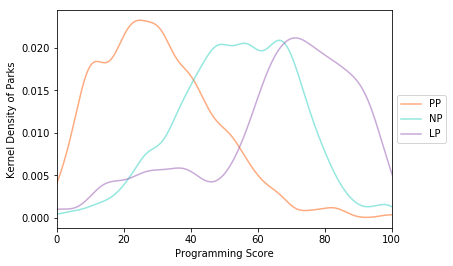

In [626]:
fig, ax= plt.subplots()

for pt, c in zip(parktypes, three_colors):
    no0[no0['TYPECATEGO']==pt]['tpa_palmm'].reset_index(drop=True)\
        .plot.kde(ax=ax, alpha=0.5, label=pt, color=c, bw_method=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Kernel Density of Parks')
plt.xlim((0,100))

#plt.savefig(join(path_exp, 'Total Events by Acre_Park Type 1_LMM_KDE.pdf'))

plt.show();

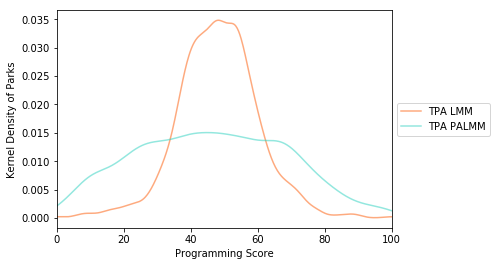

In [627]:
fig, ax= plt.subplots()

no0['tpa_lmm'].reset_index(drop=True).plot.kde(ax=ax, alpha=0.5, label='TPA LMM', color=three_colors[0], bw_method=0.2)
no0['tpa_palmm'].reset_index(drop=True).plot.kde(ax=ax, alpha=0.5, label='TPA PALMM', color=three_colors[1], bw_method=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Kernel Density of Parks')
plt.xlim((0,100))

#plt.savefig(join(path_exp, 'Total Events by Acre_Park Type or Not_LMM_KDE.pdf'))

plt.show();

In [628]:
#no0.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190806_TP and TPA Scores_AllParks.csv")

# Total Permits per Person and per Person per Person Acre: by Park Type with MM and LMM Normalization
* tppop: total permits per person (total permits divided by Pop_nearPark
* tppopdens: total permits per person per person acre (total premits divided by popdens)
* tppop_mm: total permits per person MM normalization
* tppop_lmm: total permits per person LMM normalization
* tppop_palmm: total permits per person LMM park adjusted normalization
* tppopdens_mm: total permits per person per person acre MM normalization
* tppopdens_lmm: total permits per person per person acre LMM normalization
* tppopdens_palmm: total permits per person per person acre LMM park adjusted normalization

In [629]:
parkiso[parkiso['GISPROPNUM'].isin(parklist)]['GISPROPNUM'].unique().shape
#number of parks with isochrones that are in the GISPROPNUM of the permit data
#the mismatch comes from the fact that the park entrance data is incomplete and only gave us 818 isochrones, 599 of which overlap

(599,)

In [630]:
no0= pd.merge(parkiso[['GISPROPNUM', 'Pop_nearPark','PopDens']], no0,  on='GISPROPNUM', how='right').dropna(axis=0)

In [631]:
no0= no0[no0['Pop_nearPark']!=0].copy()

In [632]:
no0.shape

(598, 20)

In [633]:
no0['tppop']= no0['tp']/no0['Pop_nearPark']
no0['tppopdens']= no0['tp']/no0['PopDens']

In [634]:
no0['tppop'].min()

2.252073473275458e-05

In [635]:
no0['tppopdens'].min()

0.004716434910482397

In [636]:
no0.shape

(598, 22)

### MM and LMM Normalization Process

In [637]:
tmax= no0['tppop'].max()
tmin= no0['tppop'].min()
tmaxd= no0['tppopdens'].max()
tmind= no0['tppopdens'].min()

no0['tppop_mm']= no0['tppop'].apply(lambda x: (x-tmin)/(tmax-tmin))*100
no0['tppop_lmm']= no0['tppop'].apply(lambda x: (np.log(x)-np.log(tmin))/(np.log(tmax)-np.log(tmin)))*100

no0['tppopdens_mm']= no0['tppopdens'].apply(lambda x: (x-tmind)/(tmaxd-tmind))*100
no0['tppopdens_lmm']= no0['tppopdens'].apply(lambda x: (np.log(x)-np.log(tmind))/(np.log(tmaxd)-np.log(tmind)))*100

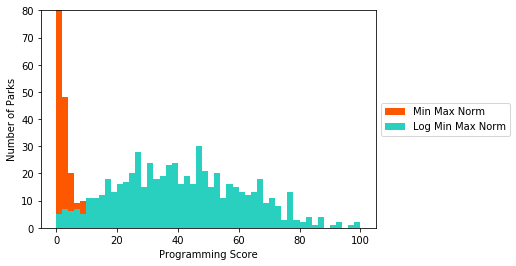

In [638]:
a= no0['tppop_mm'].values
b= no0['tppop_lmm'].values

bins= np.arange(0, 102, 2)

plt.hist(a, bins, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins, label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Events by Population_MM_LMM.pdf'))

plt.show();

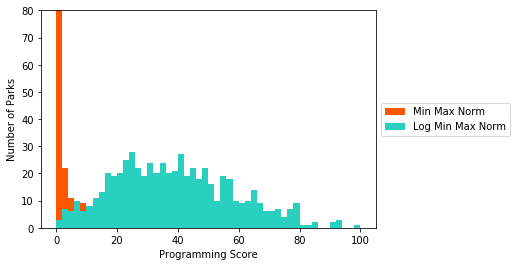

In [639]:
a= no0['tppopdens_mm'].values
b= no0['tppopdens_lmm'].values

bins= np.arange(0, 102, 2)

plt.hist(a, bins, label='Min Max Norm', color='#FD5700')
plt.hist(b, bins,  label='Log Min Max Norm', color='#29D0BF')

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Events by Population Density_MM and LMM.pdf'))

plt.show();

### Adjust by Park Type

In [640]:
fordf2= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['tppop'].values
    if len(v)>0:
        fordf2.append([p, v.max(), v.min()])

minmaxes2= pd.DataFrame(np.array(fordf2), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [641]:
minmaxes2

,MAX,MIN
TYPECATEGO,,
LP,0.49758842704892586,0.0002632827364054401
NP,0.57303944279197,3.10034162849904e-05
PP,0.021156385234059643,2.252073473275458e-05


In [642]:
fordf2= []

for p in park_types:
    v= no0[no0['TYPECATEGO']==p]['tppopdens'].values
    if len(v)>0:
        fordf2.append([p, v.max(), v.min()])

minmaxes3= pd.DataFrame(np.array(fordf2), columns=['TYPECATEGO', 'MAX', 'MIN']).set_index('TYPECATEGO')

In [643]:
for n, s in minmaxes2.iteritems():
    minmaxes2[n]= s.astype(np.float32)

In [644]:
for n, s in minmaxes3.iteritems():
    minmaxes3[n]= s.astype(np.float32)

In [645]:
no0['tppop_palmm']= [park_type_adjusted(x, pt, minmaxes2) for x, pt in no0[['tppop', 'TYPECATEGO']].itertuples(index=False)]

In [646]:
no0[no0['tppop_palmm']==np.inf].loc[:]
#Checks for infinite values

,GISPROPNUM,Pop_nearPark,PopDens,TYPECATEGO,index,ACRES,2013,2014,2015,2016,...,tpa_mm,tpa_lmm,tpa_palmm,tppop,tppopdens,tppop_mm,tppop_lmm,tppopdens_mm,tppopdens_lmm,tppop_palmm


In [647]:
no0['tppopdens_palmm']= [park_type_adjusted(x, pt, minmaxes3) for x, pt in no0[['tppopdens', 'TYPECATEGO']].itertuples(index=False)]

In [648]:
no0['tppop_palmm']= no0['tppop_palmm'].abs()

In [649]:
no0['tppopdens_palmm']= no0['tppopdens_palmm'].abs()

In [650]:
tppop_palmm= no0['tppop_palmm'].values

In [651]:
tppopdens_palmm= no0['tppopdens_palmm'].values

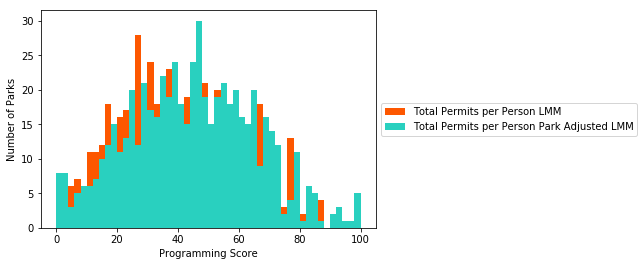

In [652]:
bins= np.arange(0, 102, 2)

tppop_lmm= no0['tppop_lmm'].values
tppop_palmm= no0['tppop_palmm'].values

plt.hist(tppop_lmm, bins, label='Total Permits per Person LMM', color=three_colors[0])
plt.hist(tppop_palmm, bins, label='Total Permits per Person Park Adjusted LMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Events by Population LMM and Park Type LMM.pdf'))

plt.show();

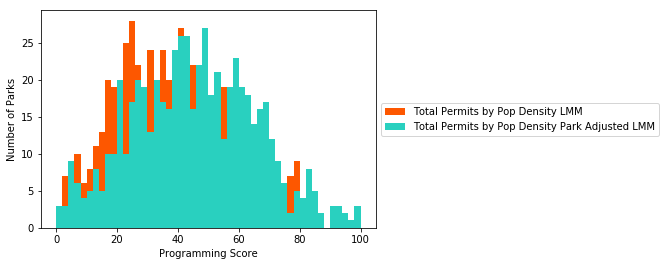

In [653]:
bins= np.arange(0, 102, 2)

tppopdens_lmm= no0['tppopdens_lmm'].values
tppopdens_palmm= no0['tppopdens_palmm'].values

plt.hist(tppopdens_lmm, bins, label='Total Permits by Pop Density LMM', color=three_colors[0])
plt.hist(tppopdens_palmm, bins, label='Total Permits by Pop Density Park Adjusted LMM', color=three_colors[1])

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.ylim((0,80))

#plt.savefig(join(path_exp, 'Total Events by Population Density LMM and Park Type LMM.pdf'))

plt.show();

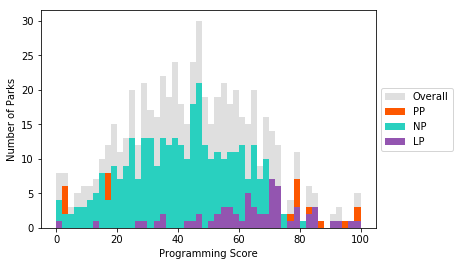

In [654]:
bins= np.arange(0, 102, 2)
tpa_palmm= no0['tppop_palmm'].values
plt.hist(tppop_palmm, bins, label='Overall', color='#dfdfdf')

for pt, c in zip(parktypes,three_colors):
    scores= no0[no0['TYPECATEGO']==pt]['tppop_palmm'].values
    plt.hist(scores, bins, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events by Population_LMM Adjusted and by Park Type.pdf'))

plt.show();

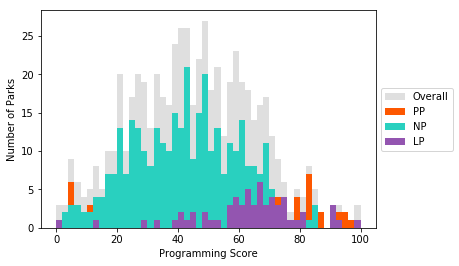

In [655]:
bins= np.arange(0, 102, 2)
tppopdens_palmm= no0['tppopdens_palmm'].values
plt.hist(tppopdens_palmm, bins,label='Overall', color='#dfdfdf')

for pt, c in zip(parktypes,three_colors):
    scores= no0[no0['TYPECATEGO']==pt]['tppopdens_palmm'].values
    plt.hist(scores, bins, label=pt, color=c)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Number of Parks')

#plt.savefig(join(path_exp, 'Total Events by Population Density_LMM Adjusted and by Park Type.pdf'))

plt.show();

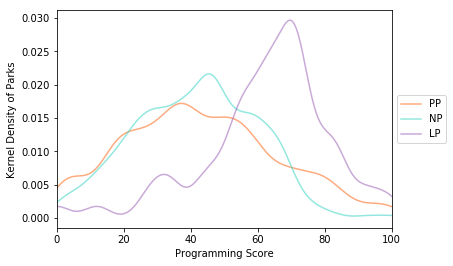

In [656]:
fig, ax= plt.subplots()

for pt, c in zip(parktypes, three_colors):
    no0[no0['TYPECATEGO']==pt]['tppop_palmm'].reset_index(drop=True)\
        .plot.kde(ax=ax, alpha=0.5, label=pt, color=c, bw_method=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.xlabel('Programming Score')
plt.ylabel('Kernel Density of Parks')
plt.xlim((0,100))

#plt.savefig(join(path_exp, 'Total Events by Population_Park Type 1_LMM_KDE.pdf'))

plt.show();

# ABCDF Scoring
* Grades (all use park adjusted LMM normalization scores):
    - tp_grade: total permits grade
    - tpa_grade: total permits per acre grade
    - tppop_grade: total permits per person grade
    - tppopdens_grade: total permits per person per person acre grade

In [657]:
scoring= \
pd.read_html(r'https://www.mooxye.com/blog/en/american-grading-system-and-gpa/', skiprows=1)[0]\
    .rename(columns={0:'Grade Range', 1:'Grade', 2:'GPA'})

In [658]:
scoring['Lower']= pd.to_numeric(scoring['Grade Range'].str.split('-| ').apply(lambda x: x[0]), errors='coerce')
scoring['Upper']= pd.to_numeric(scoring['Grade Range'].str.split('-| ').apply(lambda x: x[1]), errors='coerce')

In [659]:
scoring.at[11,'Lower']= 0

In [660]:
scoring= scoring[::-1].reset_index(drop=True)

In [661]:
no0['tp_grade']= \
pd.cut(no0['tp_palmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tp_grade']= no0['tp_grade'].astype(str)

no0['tpa_grade']= \
pd.cut(no0['tpa_palmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tpa_grade']= no0['tpa_grade'].astype(str)

no0['tppop_grade']= \
pd.cut(no0['tppop_palmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tppop_grade']= no0['tppop_grade'].astype(str)

no0['tppopdens_grade']= \
pd.cut(no0['tppopdens_palmm'],
       bins=np.insert(scoring['Upper'].values, 0, -1),
       include_lowest=False, labels=scoring['Grade'].values)
no0['tppopdens_grade']= no0['tppopdens_grade'].astype(str)

In [662]:
fff= pd.merge(parks[['GISPROPNUM', 'SIGNNAME']], no0, on='GISPROPNUM', how='right')

## Exports for Comparison
* grades: a spreadsheet of all park grades
* scores: a dataset of all park scores (park adjusted log min max normalization)
* scores2: all the initial values corresponding to the park scores

In [455]:
grades= no0.set_index(['GISPROPNUM','TYPECATEGO']).loc[:,'tp_grade':]
grades;

In [456]:
scores= no0.set_index(['GISPROPNUM','TYPECATEGO']).loc[:,['tp_palmm','tpa_palmm','tppop_palmm','tppopdens_palmm']]
scores;

In [457]:
scores2= no0.set_index(['GISPROPNUM','TYPECATEGO']).loc[:,['tp','tpa','tppop','tppopdens']]
scores2;

In [458]:
grades.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - New Categories\190729_TParks by Acre and Pop.csv")

In [459]:
scores.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop.csv")

In [460]:
scores2.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - Scores\190729_TParks by Acre and Pop_NoNormalization.csv")

## Percentile comparison: 25th, median, and 75th

In [449]:
dsum= [[no0['tp_palmm'].median(),no0['tp_palmm'].quantile(.25),no0['tp_palmm'].quantile(.75)],[no0['tpa_palmm'].median(),no0['tpa_palmm'].quantile(.25),no0['tpa_palmm'].quantile(.75)],[no0['tppop_palmm'].median(),no0['tppop_palmm'].quantile(.25),no0['tppop_palmm'].quantile(.75)],[no0['tppopdens_palmm'].median(),no0['tppopdens_palmm'].quantile(.25),no0['tppopdens_palmm'].quantile(.75)]]

In [450]:
dsum

[[40.0, 22.0, 56.0],
 [48.0, 30.0, 66.0],
 [44.0, 29.0, 59.0],
 [44.0, 30.0, 59.0]]

In [451]:
summary= pd.DataFrame(data=dsum,columns=['Median','25th Percentile','75th Percentile'],index=['Total Permit Grade','Permits per Acre','By Population','By Population Density'])
summary.to_csv(r"M:\NY4P Metrics Research 18034\03_GIS+ANALYSIS\01_DATA\Processed\Initial Options - New Categories\190722_SummaryStats_NoOutliers.csv")